# Imports and setup

In [151]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)

In [152]:
cmap = plt.get_cmap('cmr.rainforest')
mpl.rc('image', cmap=cmap.name)

In [270]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [4]:
data = at.Table.read("../../CATS_Workshop/cats/data/joined-GD-1.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

In [71]:
np.max(cat['phi2'])

3.3488445561550395

In [5]:
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

stream='GD-1'


p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=3)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


        Use @ instead. [gala.coordinates.greatcircle]


-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -13.031354268696703, -3.10816045358226
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-13.299030895391816, -3.178220550031381, 0.3944380722056084, 0.517241359741969] 

Producing the polygon and mask


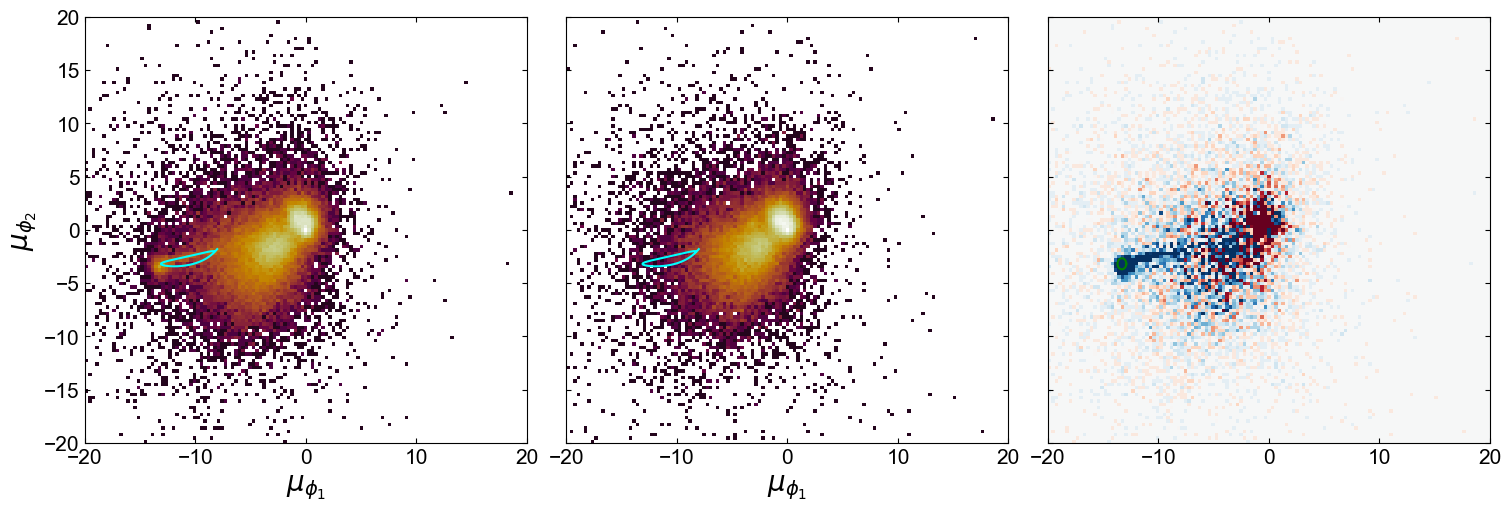

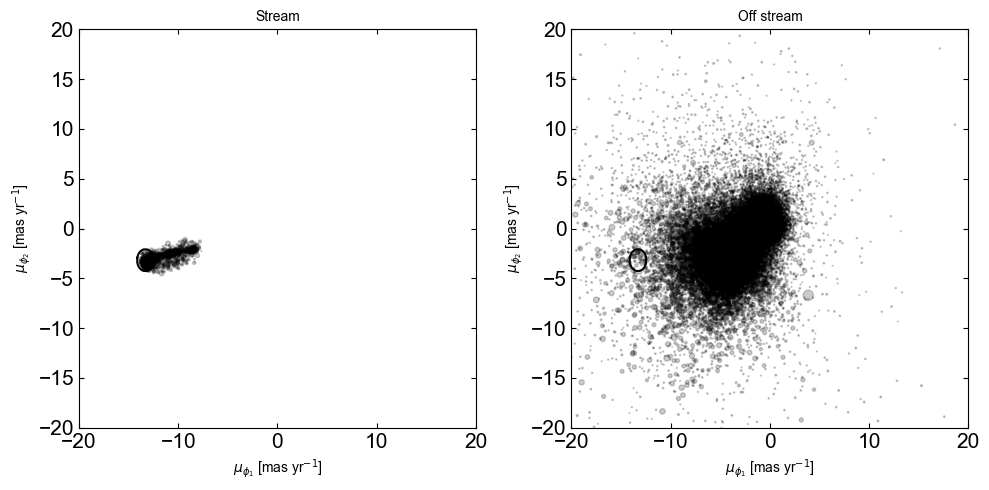

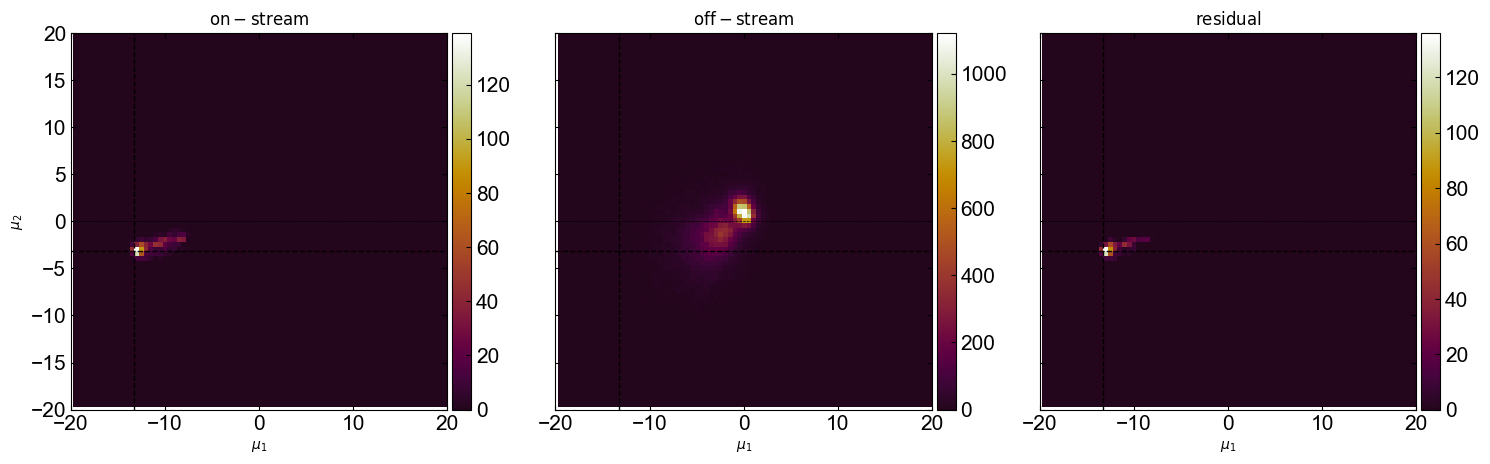

In [17]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [18]:
# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)
p.pmprint.vertices

        Use @ instead. [gala.coordinates.greatcircle]


array([[-15.09996078,  -5.41743859],
       [-15.09996078,   0.19860289],
       [ -6.01001683,   0.19860289],
       [ -6.01001683,  -5.41743859]])

In [154]:
# GD1Base.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
# GD1Base.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
# GD1Base.default_grids['phi2'] = np.linspace(np.min(cat['phi2']),np.max(cat['phi2']), 100)

# GD1Base.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
# GD1Base.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
# GD1Base.coord_bounds['phi2'] = (np.min(cat['phi2']),np.max(cat['phi2']))



# GD1BackgroundModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
# GD1BackgroundModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
# GD1BackgroundModel.default_grids['phi2'] = np.linspace(np.min(cat['phi2']),np.max(cat['phi2']), 100)

# GD1BackgroundModel.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
# GD1BackgroundModel.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
# GD1BackgroundModel.coord_bounds['phi2'] = (np.min(cat['phi2']),np.max(cat['phi2']))

# GD1StreamModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
# GD1StreamModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)

In [271]:
GD1Base.coord_bounds

{'phi1': (-100, 20), 'phi2': (-8, 3.3), 'pm1': (-15, -6.0), 'pm2': (-5.4, 0.2)}

In [272]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [273]:
len(bkg_data['phi1'])

36459

In [274]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

In [ ]:
plot_data_projections(data=bkg_data, grids=GD1Base.default_grids,
                      smooth=1);

# Background

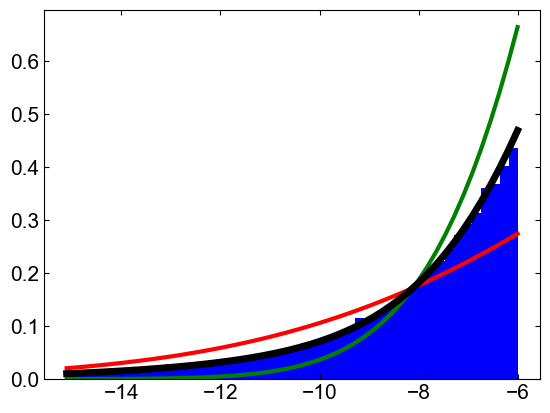

In [276]:
mean1 = 0 ; std_dev1 = np.e**1.2
mean2 = 5 ; std_dev2 = np.e**2

_, x, _ = plt.hist(bkg_data['pm1'], density=True, bins=50, color='b')

line1 = scs.truncnorm.pdf(x, (np.min(x)-mean1) / std_dev1, (np.max(x)-mean1) / std_dev1, loc=mean1, scale=std_dev1)
line2 = scs.truncnorm.pdf(x, (np.min(x)-mean2) / std_dev2, (np.max(x)-mean2) / std_dev2, loc=mean2, scale=std_dev2)
plt.plot(x, line1, c='g', lw=3)
plt.plot(x, line2, c='r', lw=3)
plt.plot(x, 0.5*(line1+line2), c='k', lw=5)
plt.show()

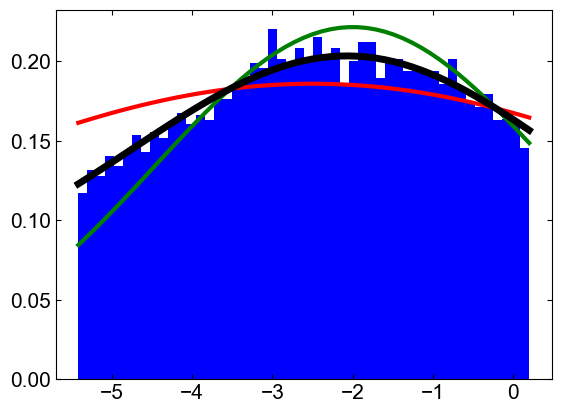

In [277]:
mean1 = -2 ; std_dev1 = np.e**0.9
mean2 = -2.5 ; std_dev2 = np.e**1.7

_, x, _ = plt.hist(bkg_data['pm2'], density=True, bins=50, color='b')

line1 = scs.truncnorm.pdf(x, (np.min(x)-mean1) / std_dev1, (np.max(x)-mean1) / std_dev1, loc=mean1, scale=std_dev1)
line2 = scs.truncnorm.pdf(x, (np.min(x)-mean2) / std_dev2, (np.max(x)-mean2) / std_dev2, loc=mean2, scale=std_dev2)
plt.plot(x, line1, c='g', lw=3)
plt.plot(x, line2, c='r', lw=3)
plt.plot(x, 0.5*(line1+line2), c='k', lw=5)
plt.show()

In [278]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    "phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    #"phi1": {'zs': np.zeros(GD1BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(GD1BackgroundModel.pm1_knots, 0.0001),
        "mean1": np.full_like(GD1BackgroundModel.pm1_knots, 0),
        "ln_std1": np.full_like(GD1BackgroundModel.pm1_knots, 1.2),
        "mean2": np.full_like(GD1BackgroundModel.pm1_knots, 5),
        "ln_std2": np.full_like(GD1BackgroundModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(GD1BackgroundModel.pm2_knots, 0.99),
        "mean1": np.full_like(GD1BackgroundModel.pm2_knots, -2.),
        "ln_std1": np.full_like(GD1BackgroundModel.pm2_knots, 0.9),
        "mean2": np.full_like(GD1BackgroundModel.pm2_knots, -2.5),
        "ln_std2": np.full_like(GD1BackgroundModel.pm2_knots, 1.7)
    },
}
background_init = GD1BackgroundModel(bkg_init_p)

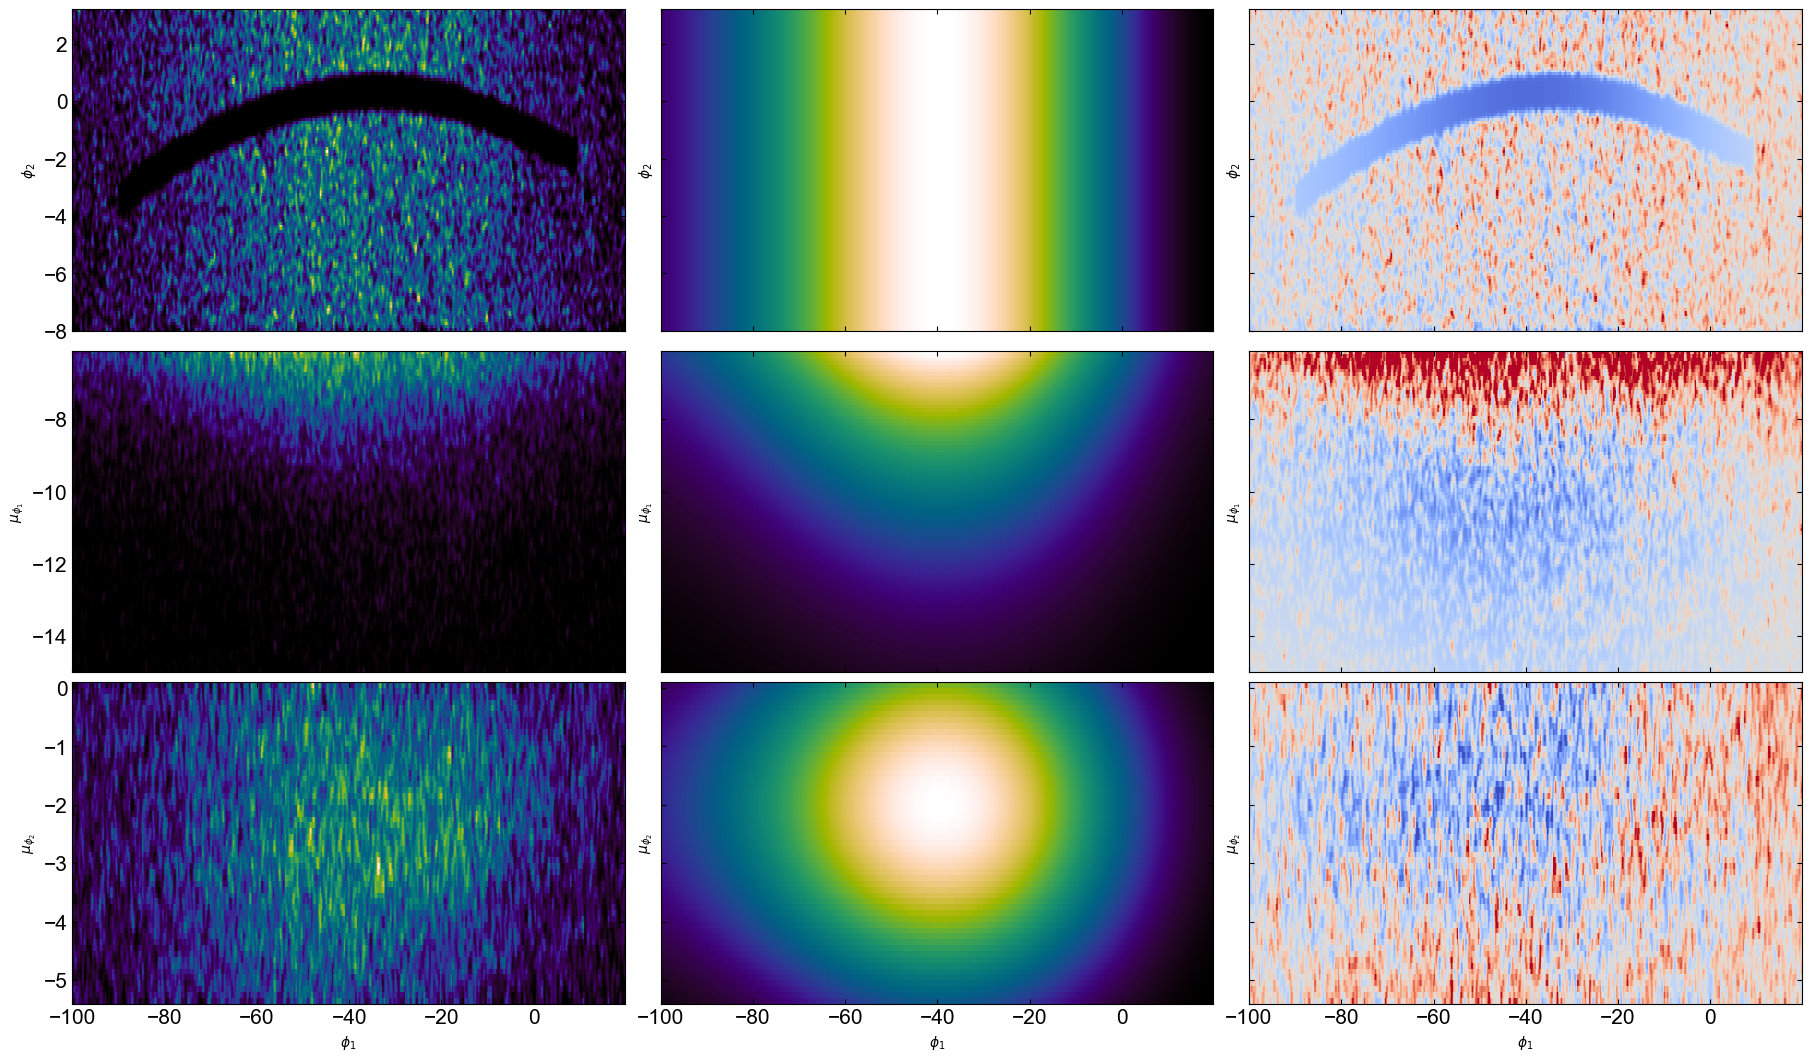

In [ ]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [280]:
background_init.coord_bounds

{'phi1': (-100, 20), 'phi2': (-8, 3.3), 'pm1': (-15, -6.0), 'pm2': (-5.4, 0.2)}

In [281]:
background_init.default_grids['pm1'].max()

-6.100000000000032

In [282]:
background_init.variables['pm2'].coord_bounds

(-5.4, 0.2)

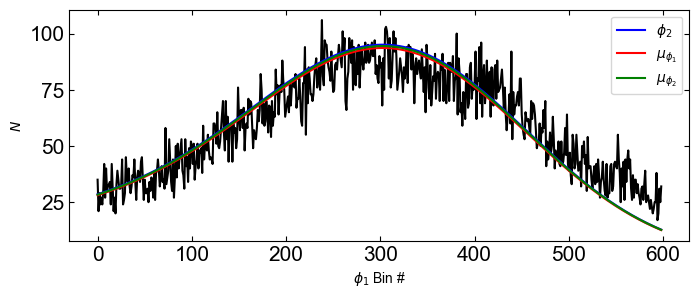

In [283]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [284]:
print(np.sum(np.exp(ln_ns['phi1','pm1'])))
print(np.sum(H_data1))

35565.924317534074
35880.0


In [285]:
def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
    optimize_kwargs["bounds"] = (
        cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
        cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
    opt_res = optimizer.run(
        init_params=cls._normalize_variable_keys(init_params),
        data=cls._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    return cls._expand_variable_keys(opt_res.params), opt_res.state

In [286]:
bkg_opt_pars, bkg_info = optimize(GD1BackgroundModel,
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = GD1BackgroundModel(bkg_opt_pars)
bkg_info

LbfgsbState(iter_num=Array(14, dtype=int64, weak_type=True), value=Array(1.0975929, dtype=float64), grad={'ln_N': Array(0.00060747, dtype=float64), 'phi1': {'zs': Array([-3.90379755e-04, -5.31896178e-04, -2.27398058e-04,  2.80755702e-04,
       -1.36961136e-04,  3.75066360e-04,  1.77607973e-04,  2.86115181e-06],      dtype=float64)}, 'phi2': {}, 'pm1': {'ln_std1': Array([-1.08863567e-04, -4.31326065e-04, -4.19481087e-04, -4.42407997e-04,
        1.91688336e-04,  6.05576590e-04,  4.10842015e-04, -2.55824194e-04,
        6.22250580e-05, -1.71107906e-04, -3.51393807e-04, -4.83516112e-04,
       -1.49298820e-04], dtype=float64), 'ln_std2': Array([-1.40807524e-04,  4.83889593e-04, -3.88373321e-04, -4.32843561e-04,
       -1.01793138e-04,  1.29700053e-04,  2.07084180e-05, -5.71393914e-04,
       -3.47928291e-04, -2.26992021e-04, -1.68190857e-04,  5.40217527e-04,
        2.55408061e-05], dtype=float64), 'mean1': Array([ 5.51881219e-06,  3.51490240e-05,  2.65002758e-05,  2.87052783e-05,
      

In [249]:
# bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
#     data=bkg_data,
#     init_params=bkg_init_p,
#     use_bounds=True,
#     jaxopt_kwargs=dict(maxiter=4096),
# )
# background_opt = GD1BackgroundModel(bkg_opt_pars)
# bkg_info

In [287]:
bkg_opt_pars

{'ln_N': Array(10.5045509, dtype=float64),
 'phi1': {'zs': Array([-2.50946524, -1.60035617, -0.70506594,  0.61541098,  1.13025016,
          1.53585017,  3.36164963,  4.49835109], dtype=float64)},
 'phi2': {},
 'pm1': {'ln_std1': Array([1.07942977, 1.00696086, 1.05721366, 1.08949308, 1.14800977,
         1.25639147, 1.25387291, 1.18109595, 1.14369874, 1.09121049,
         1.09566476, 0.99846081, 1.12281272], dtype=float64),
  'ln_std2': Array([1.82018574, 1.88060208, 1.91312208, 1.7445056 , 1.76389504,
         1.67527662, 1.84989343, 1.89451647, 1.90880846, 1.88490133,
         1.87587187, 1.98470418, 1.79750533], dtype=float64),
  'mean1': Array([ 0.00497522,  0.01168676,  0.00548981, -0.000532  , -0.00803336,
         -0.01818709, -0.01425056, -0.00608772,  0.00019077,  0.00345087,
          0.00443306,  0.01370385,  0.00186726], dtype=float64),
  'mean2': Array([5.00859997, 5.00812513, 5.00689684, 5.01358709, 5.01536772,
         5.01796281, 5.01161273, 5.00904416, 5.00440475, 5.00

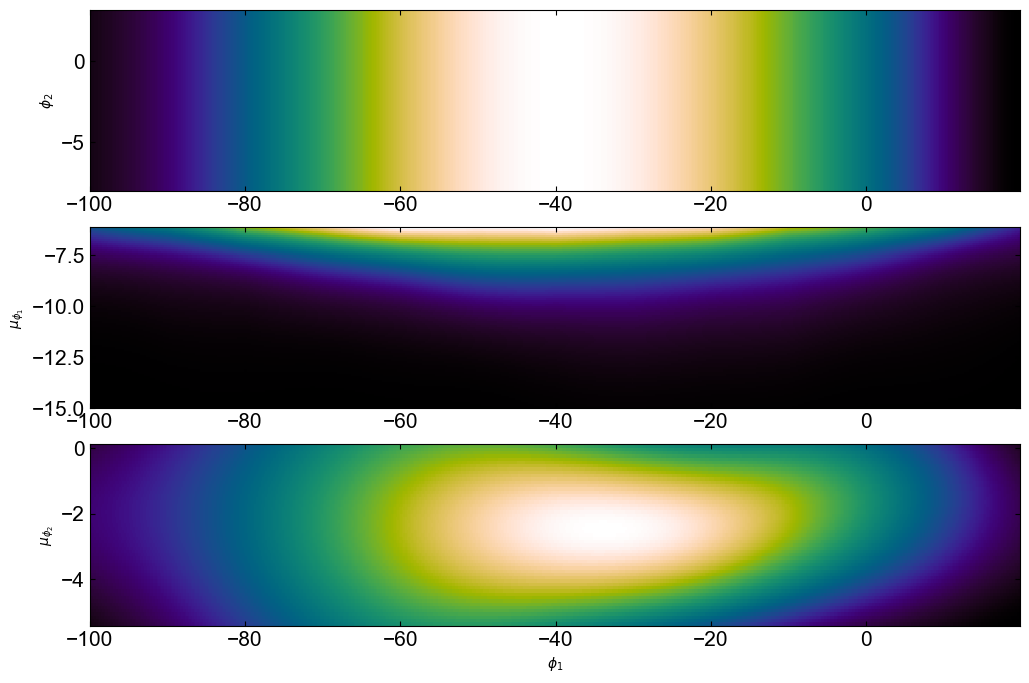

In [288]:
fig, axs = plt.subplots(3,1,figsize=(12,8))
_ = background_opt.plot_model_projections(axes=axs)

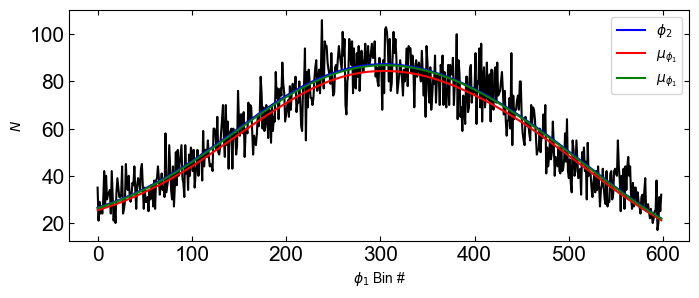

In [289]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)
grids, ln_ns = background_opt.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_1}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")
fig.savefig('test_residual.png')

Based on some of these plots, it seems to me that the algorithm is comparing the total density of the entire distribution of the proper motions against the total data just in the region specified. So for instance, it is happy that the integrated density of proper motion in phi1 (from -inf to inf) is equal to the number of data points from ~-7 to ~-15. That means that in general, the model is not dense enough pretty much everywhere.

# Stream

In [294]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-90, 10, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [295]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

        Use @ instead. [gala.coordinates.greatcircle]


In [296]:
np.e**10

22026.465794806703

In [297]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(GD1StreamModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(GD1StreamModel.phi2_knots),
        "ln_std": np.full_like(GD1StreamModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(GD1StreamModel.pm1_knots),
        "ln_std": np.full_like(GD1StreamModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(GD1StreamModel.pm2_knots),
        "ln_std": np.full_like(GD1StreamModel.pm2_knots, -1)
    }
}

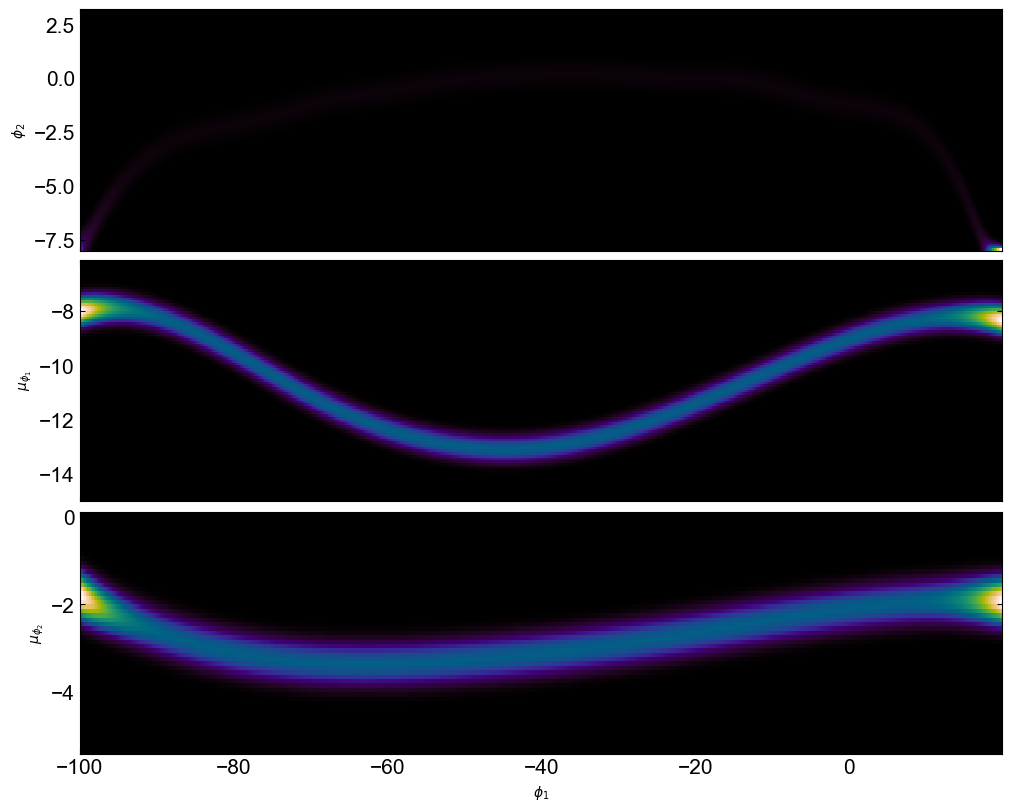

In [298]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [299]:
stream_init_p

{'ln_N': 7.213768308118642,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-8.24173489e+00, -3.94275802e+00, -2.45380431e+00, -1.86048384e+00,
         -1.03345998e+00, -6.09293288e-01, -1.24647276e-01,  1.07382554e-01,
          1.90458011e-01,  1.01875713e-01, -1.09002124e-02, -2.10482931e-01,
         -9.78888085e-01, -1.46285208e+00, -3.47866928e+00, -1.11767560e+01]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
         -0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm1': {'mean': array([ -8.01001683,  -8.77103682, -11.15172534, -12.76884806,
         -13.02597314, -11.97714148, -10.18789348,  -8.59629564,
          -8.319378  ]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-1.80139711, -3.24562547, -3.27612746, -2.78970843, -2.09902309,
         -1.99723637]),
  'ln_

In [300]:
stream_opt_pars, info = GD1StreamModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = GD1StreamModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.99552352, dtype=float64, weak_type=True), success=True, status=0, iter_num=855, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -4.00868847e-05  4.21886815e-05
  -1.21552849e-04 -5.26748814e-06 -1.28963825e-04 -7.79208790e-05
   3.85154494e-06 -6.29776186e-05  3.75808659e-05  2.55705108e-05
  -8.33118551e-05  1.58257849e-05 -4.91335318e-05 -5.29869179e-05
  -1.28248854e-05 -1.54281917e-04 -1.69147511e-04  1.73642159e-05
   3.56709063e-05 -1.89883700e-04  4.51314222e-05  0.00000000e+00
   1.38950496e-04  3.93471991e-05  1.07983658e-05  2.22989674e-06
   2.61868931e-07 -1.35553486e-07 -2.57377584e-06 -1.12365422e-05
   1.91570285e-05  6.91158162e-06 -3.60052707e-06 -3.91060486e-06
   3.64339267e-06 -1.46896793e-05  2.60000480e-05 -4.36059612e-05
  -7.83679258e-06  2.00454963e-05 -1.92186290e-05 -4.11264954e-05
   3.98573340e-05 -4.95334536e-05 -4.33642696e-05 -8.62068041

Text(0, 0.5, '$\\phi_2$')

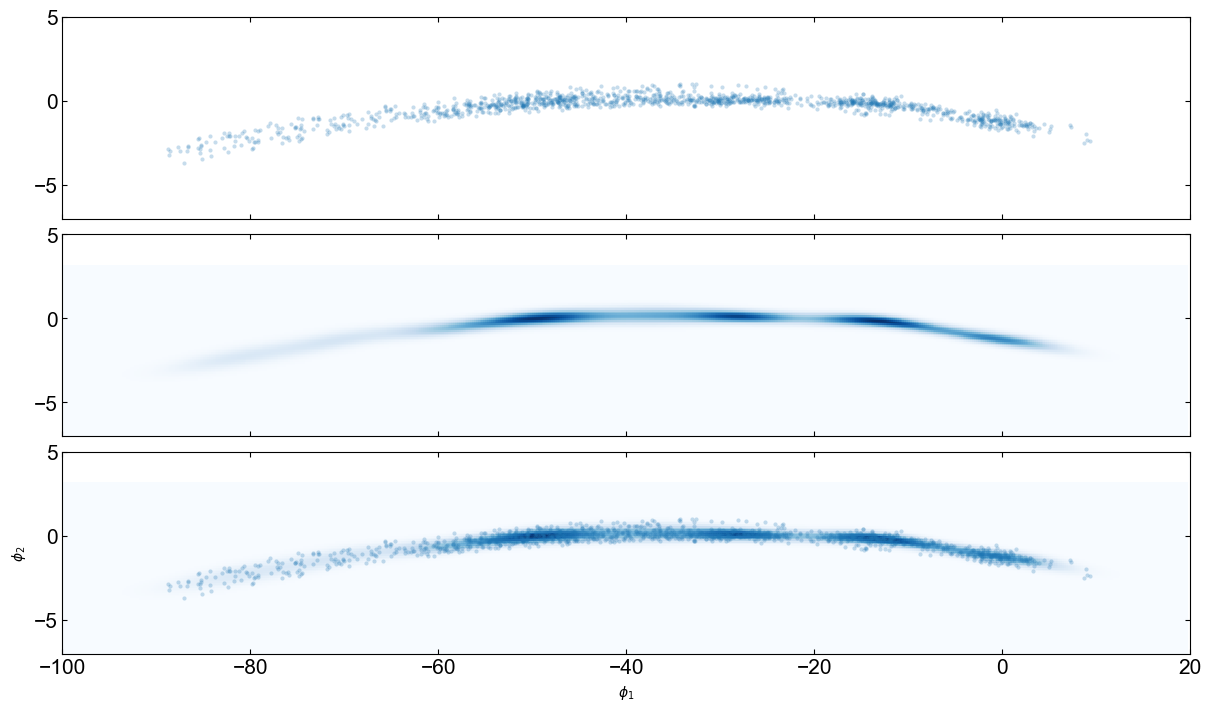

In [301]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

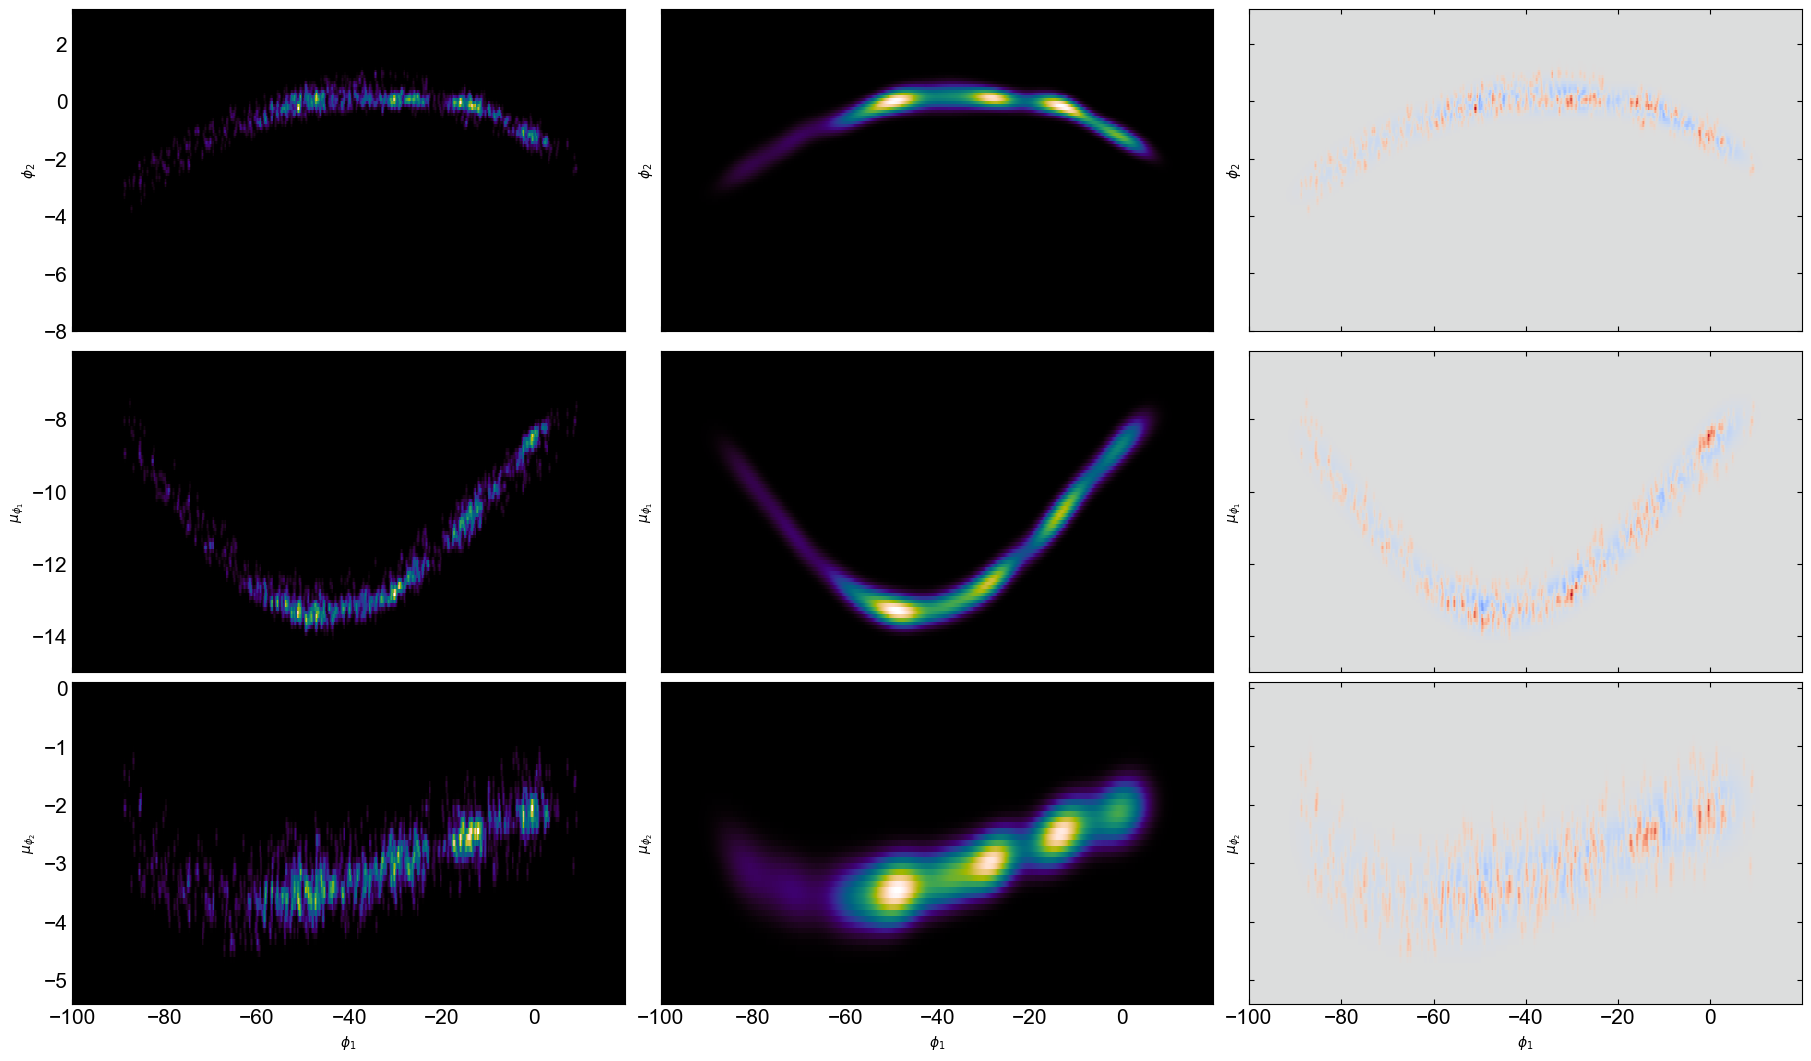

In [302]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [303]:
Components = [GD1StreamModel, GD1BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [304]:
mix_init = StreamMixtureModel(mix_params0, Components)

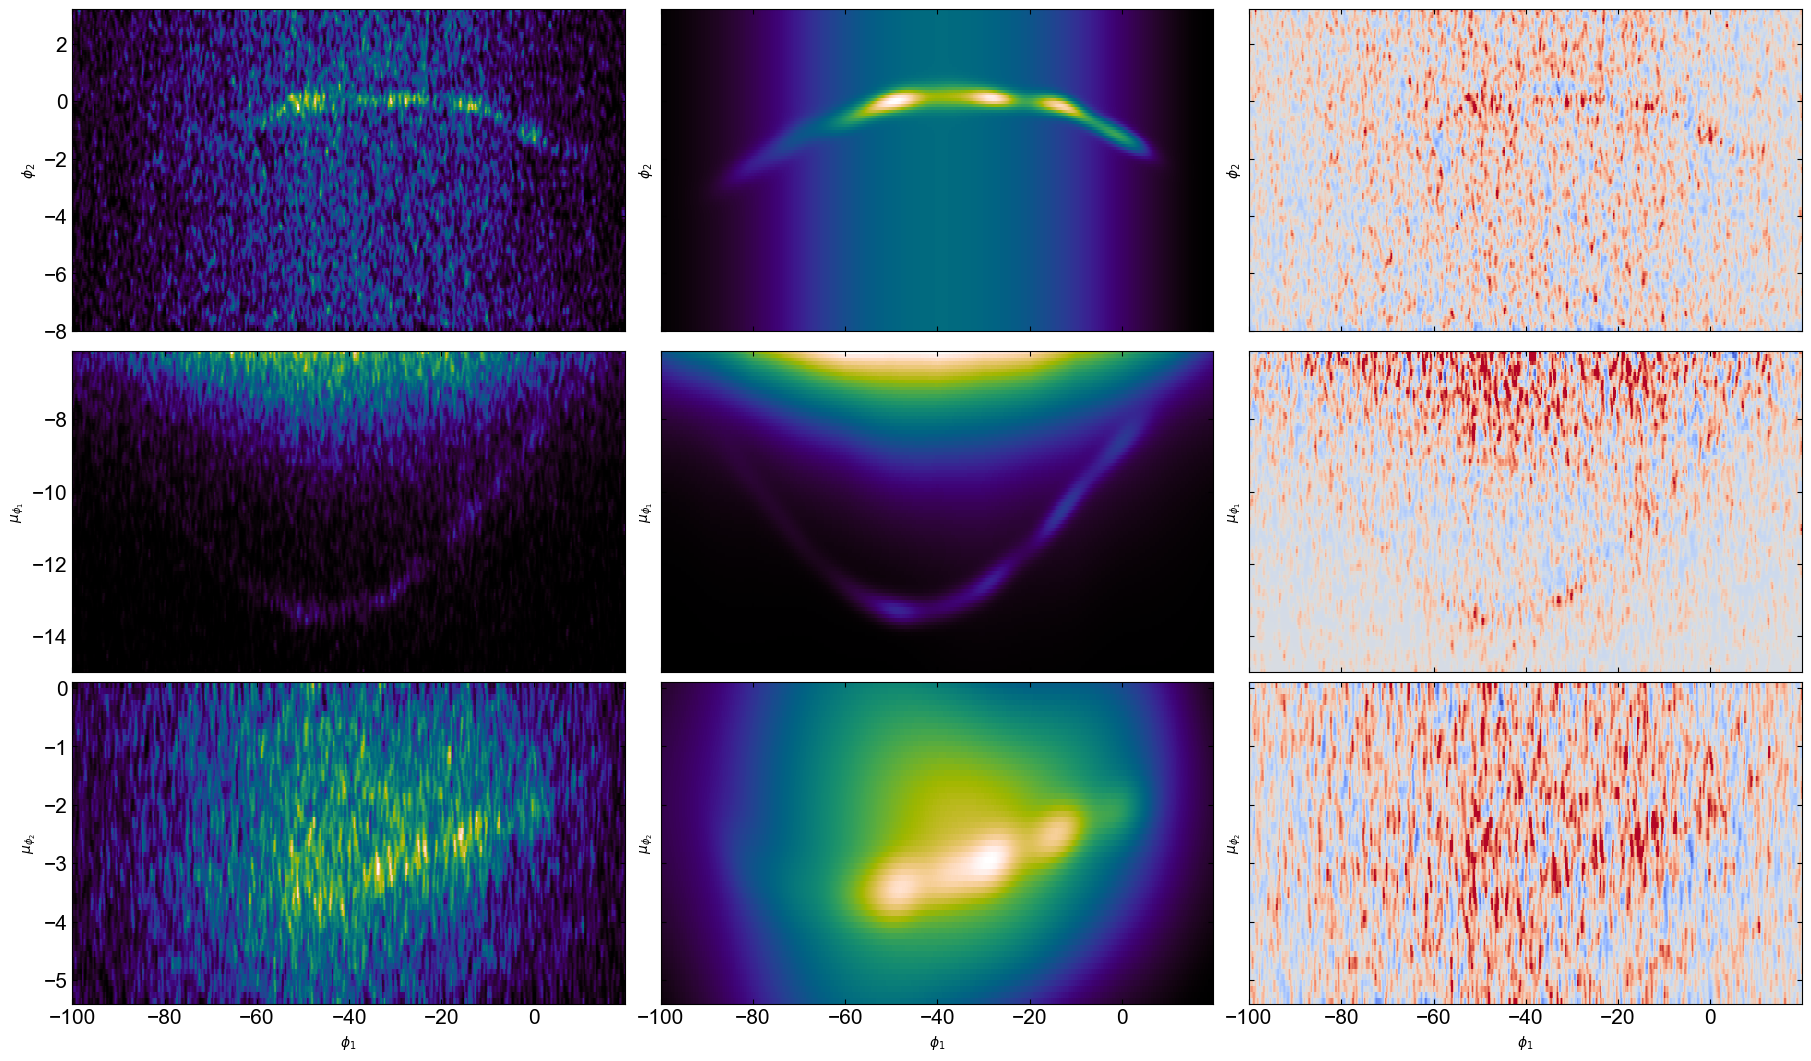

In [305]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [306]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(0.89099915, dtype=float64, weak_type=True), success=True, status=0, iter_num=1893, hess_inv=LbfgsInvHessProduct(sk=[[ 5.01494121e-05 -1.87679003e-04  3.48468964e-04 ... -5.59523756e-05
   2.35160463e-05 -1.37976014e-03]
 [-2.48805086e-05 -4.17520256e-06  2.18721183e-05 ...  5.84768100e-06
  -8.53860346e-06  8.76962919e-06]
 [ 8.58322494e-05 -3.54254964e-05 -2.20507310e-05 ... -1.20763046e-05
  -1.14908045e-05 -3.28152702e-04]
 ...
 [ 1.12741596e-05 -1.45546386e-05  8.33022671e-05 ... -7.10282641e-06
   1.22273792e-05  3.91999701e-05]
 [ 4.75545150e-06 -3.27913994e-05  1.44105066e-04 ...  6.98021779e-06
  -7.56347296e-06 -6.15037833e-05]
 [-9.25022461e-06 -7.22199570e-05  2.62464535e-04 ...  1.34992019e-05
  -2.81896778e-05 -2.40287523e-04]], yk=[[ 4.66508405e-05  1.77829012e-07  2.86755819e-06 ...  5.65706650e-07
  -1.76192335e-06 -5.29879192e-07]
 [-2.35042915e-05  7.82459628e-09  8.50084546e-08 ...  1.15891968e-07
  -4.15355633e-07 -1.74274461e-08]
 [ 

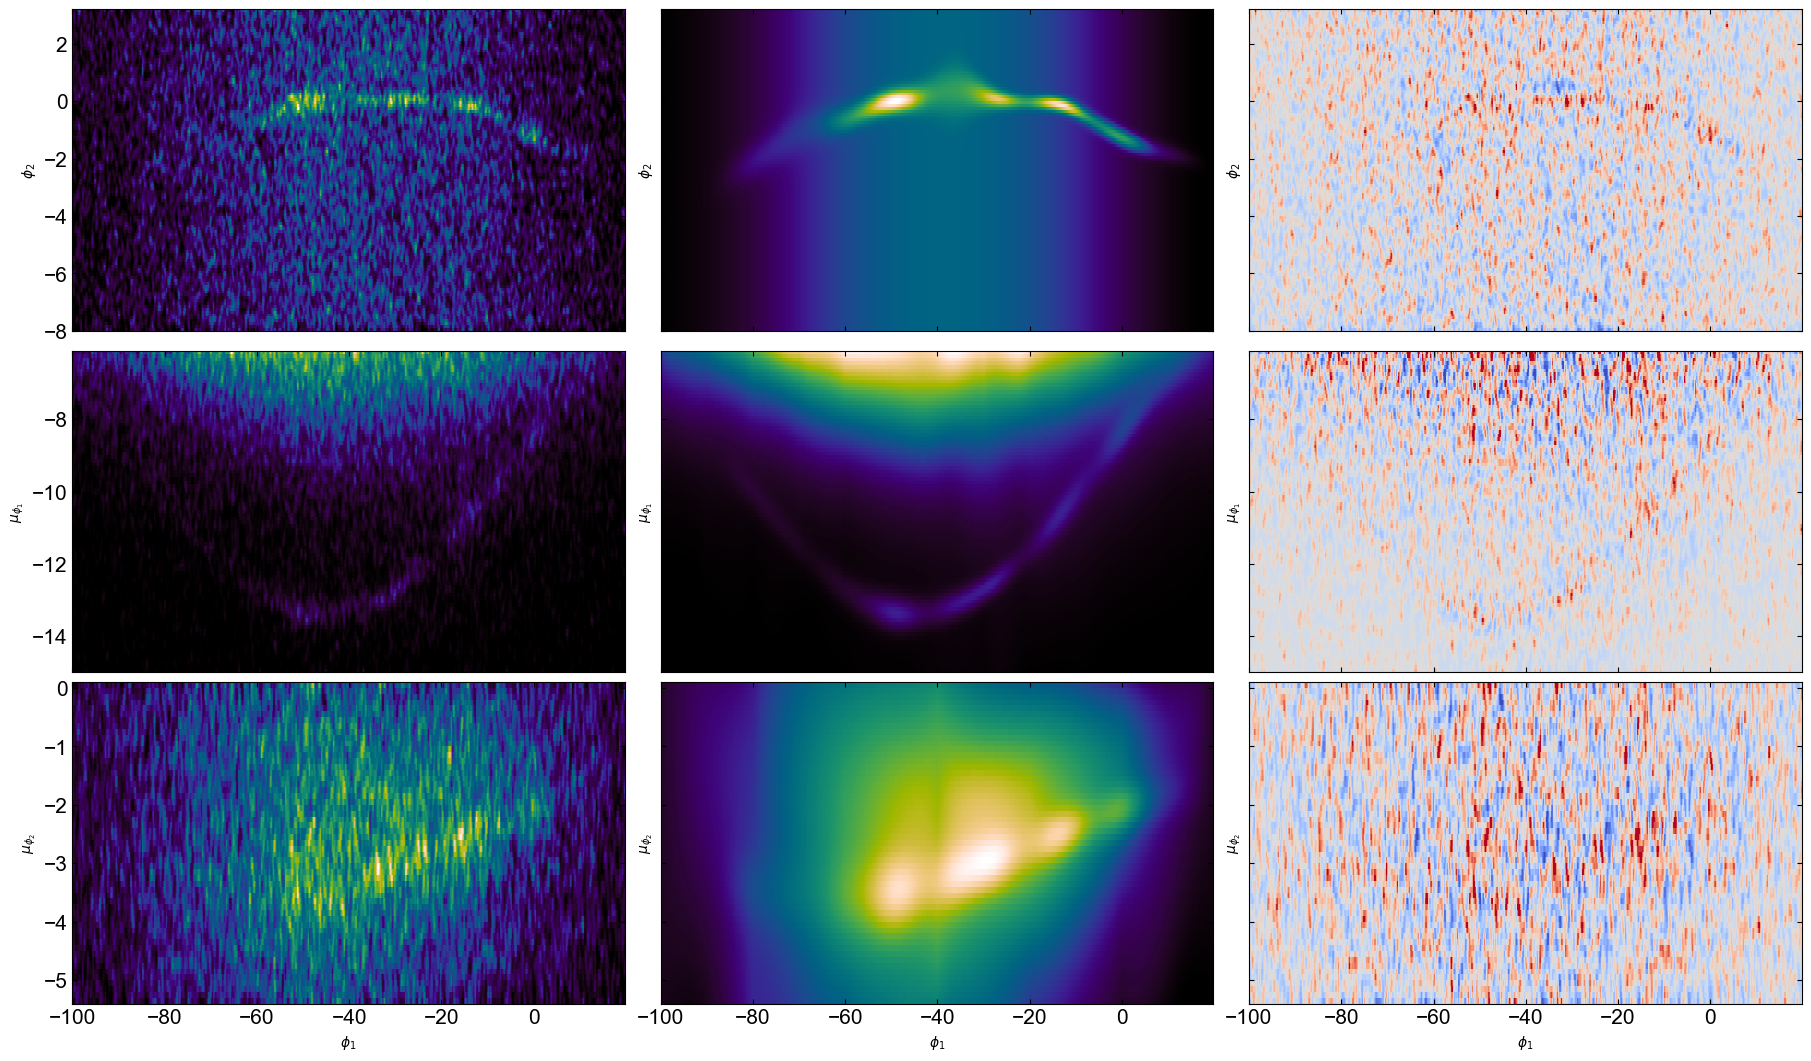

In [307]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [308]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(GD1OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

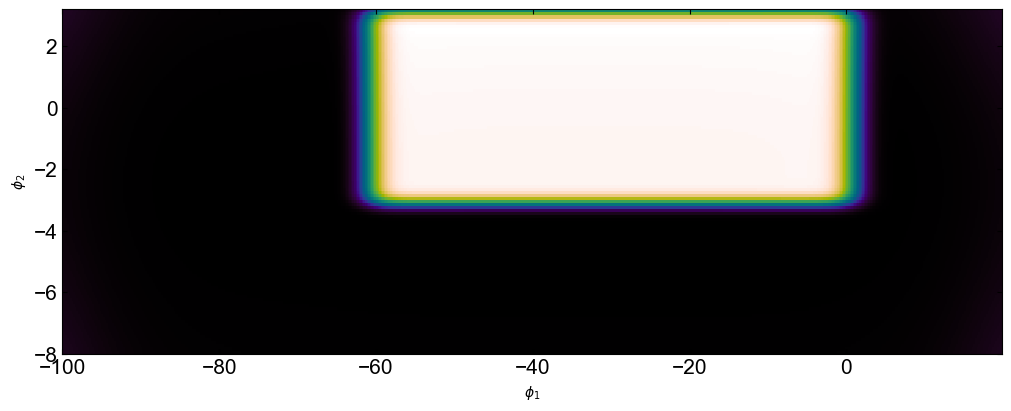

In [309]:
offtrack_model0 = GD1OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [310]:
full_Components = [GD1StreamModel, GD1BackgroundModel, GD1OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [335]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [336]:
full_mix_params0['offtrack'][('phi1', 'phi2')]['zs'].shape

(874,)

In [337]:
tied_params

[(('offtrack', 'pm1'), ('stream', 'pm1')),
 (('offtrack', 'pm2'), ('stream', 'pm2'))]

In [ ]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    #tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

In [ ]:
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

In [ ]:
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5))

In [217]:
full_mix_opt_pars['stream']['pm1']

{'ln_std': Array([-0.86541515, -0.91688066, -1.06186763, -1.15438145, -1.25354065,
        -1.14996269, -1.09284736, -0.96356562, -0.96085753], dtype=float64),
 'mean': Array([ -8.23973304,  -9.00712161, -11.39111032, -13.03184141,
        -13.23629789, -12.15145871, -10.11117072,  -8.23814473,
         -8.53670427], dtype=float64)}

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

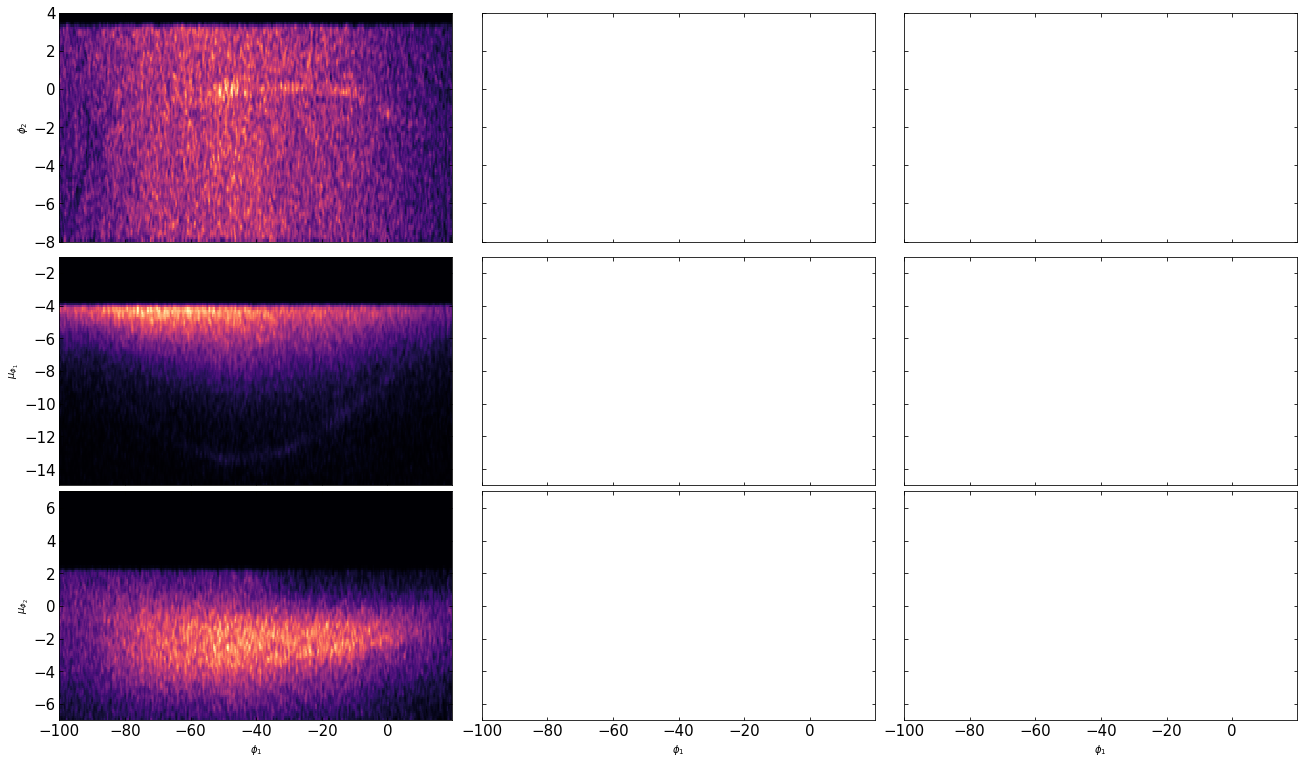

In [221]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")